# 2. Outlier detection

## Environment setup

### Install TGL package

In [1]:
import os

In [2]:
os.environ['PATH'] = "/Users/ivandonofrio/Workplace/Notebooks/venv/bin:" + os.environ['PATH']

In [3]:
%%sh
git clone git@github.com:donofiva/TemporalGraphLearning.git
cd TemporalGraphLearning
pip install .
cd ..
rm -r TemporalGraphLearning

Cloning into 'TemporalGraphLearning'...


Processing /Users/ivandonofrio/Workplace/Notebooks/TemporalGraphLearning
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for temporal_graph_learning: filename=temporal_graph_learning-0.0.1-py3-none-any.whl size=11874 sha256=4cb449f2984e9861ec506e2f3530530f05465de0bb3d0d99625345ff437b3488
  Stored in directory: /private/var/folders/qv/mvb8szpn0zgfn8vn02k7c24m0000gn/T/pip-ephem-wheel-cache-pwmuv436/wheels/39/db/05/f395aacb8d67d0f880772d6a24131398880b7ba726b6f1820e
Successfully built temporal_graph_learning
  Attempting uninstall: temporal_graph_learning
    Found existing installation: tempo

### Define constants and configurations

In [4]:
OUTPUT_PATH = 'outputs/outlier_detection'

In [5]:
BINS = 200

In [6]:
COL_RATIO = 6
HISTOGRAM_ROW_RATIO = 20
TIMESERIES_ROW_RATIO = 120

## Dependencies

In [7]:
import os
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from temporal_graph_learning.abstraction.Dataset import Dataset
from temporal_graph_learning.abstraction.Timeseries import Timeseries
from temporal_graph_learning.charts.Plots import Plots
from temporal_graph_learning.charts.Plot import Plot
from temporal_graph_learning.charts.Histogram import Histogram
from temporal_graph_learning.charts.Lineplot import Lineplot
from temporal_graph_learning.charts.Heatmap import Heatmap
from temporal_graph_learning.charts.Scatterplot import Scatterplot
from temporal_graph_learning.charts.Text import Text
from temporal_graph_learning.charts.AutoCorrelation import AutoCorrelation
from temporal_graph_learning.io.FileManager import FileManager

In [9]:
from temporal_graph_learning.data.mask.ConditionalMasker import (
    ConditionalMasker, 
    MaskingComparison, 
    MaskingRule, 
    MaskingCondition
)

## Read data

In [10]:
timeseries_dataset = Dataset(pd.read_csv('inputs/timeseries.csv'))

## Outlier removal

### Define outlier rules

In [11]:
dimensions = set(timeseries_dataset.get_dataframe().columns).difference(['TURBINE', 'DAY', 'TIMESLOT'])
dimensions = list(dimensions)

In [12]:
conditions = [
    MaskingRule(
        dimensions=dimensions,
        conditions=[
            MaskingCondition('ACTIVE_POWER', MaskingComparison.LESS, 0)
        ]
    ),
    MaskingRule(
        dimensions=dimensions,
        conditions=[
            MaskingCondition('WIND_SPEED', MaskingComparison.LESS, 1),
            MaskingCondition('ACTIVE_POWER', MaskingComparison.GREATER, 10)
        ]
    ),
    MaskingRule(
        dimensions=dimensions,
        conditions=[
            MaskingCondition('WIND_SPEED', MaskingComparison.LESS, 2),
            MaskingCondition('ACTIVE_POWER', MaskingComparison.GREATER, 100)
        ]
    ),
    MaskingRule(
        dimensions=dimensions,
        conditions=[
            MaskingCondition('WIND_SPEED', MaskingComparison.LESS, 3),
            MaskingCondition('ACTIVE_POWER', MaskingComparison.GREATER, 200)
        ]
    ),
    MaskingRule(
        dimensions=dimensions,
        conditions=[
            MaskingCondition('WIND_SPEED', MaskingComparison.GREATER, 2.5),
            MaskingCondition('ACTIVE_POWER', MaskingComparison.EQUAL, 0)
        ]
    ),
    MaskingRule(
        dimensions=dimensions,
        conditions=[
            MaskingCondition('WIND_SPEED', MaskingComparison.EQUAL, 0),
            MaskingCondition('WIND_DIRECTION', MaskingComparison.EQUAL, 0),
            MaskingCondition('EXTERNAL_TEMPERATURE', MaskingComparison.EQUAL, 0)
        ]
    ),
    MaskingRule(
        dimensions=dimensions,
        conditions=[
            MaskingCondition('EXTERNAL_TEMPERATURE', MaskingComparison.LESS, -21)
        ]
    ),
    MaskingRule(
        dimensions=dimensions,
        conditions=[
            MaskingCondition('INTERNAL_TEMPERATURE', MaskingComparison.LESS, -21)
        ]
    ),
    MaskingRule(
        dimensions=dimensions,
        conditions=[
            MaskingCondition('EXTERNAL_TEMPERATURE', MaskingComparison.GREATER, 60)
        ]
    ),
    MaskingRule(
        dimensions=dimensions,
        conditions=[
            MaskingCondition('INTERNAL_TEMPERATURE', MaskingComparison.GREATER, 70)
        ]
    ),
    MaskingRule(
        dimensions=dimensions,
        conditions=[
            MaskingCondition('WIND_DIRECTION', MaskingComparison.GREATER, 180),
            MaskingCondition('WIND_DIRECTION', MaskingComparison.LESS, -180)
        ]
    ),
    MaskingRule(
        dimensions=dimensions,
        conditions=[
            MaskingCondition('NACELLE_DIRECTION', MaskingComparison.GREATER, 720),
            MaskingCondition('NACELLE_DIRECTION', MaskingComparison.LESS, -720)
        ]
    ),
    MaskingRule(
        dimensions=dimensions,
        conditions=[
            MaskingCondition('PITCH_ANGLE_FIRST_BLADE', MaskingComparison.GREATER, 89),
            MaskingCondition('PITCH_ANGLE_SECOND_BLADE', MaskingComparison.GREATER, 89),
            MaskingCondition('PITCH_ANGLE_THIRD_BLADE', MaskingComparison.GREATER, 89)
        ]
    )
]

### Remove outliers

In [13]:
conditional_masker = ConditionalMasker(conditions)

In [14]:
timeseries_dataset = Dataset(
    conditional_masker.fit_transform(
        timeseries_dataset.get_dataframe()
    )
)

## General timeseries description

In [40]:
timeseries_dataset.get_dataframe().describe()

,TURBINE,DAY,WIND_SPEED,WIND_DIRECTION,EXTERNAL_TEMPERATURE,INTERNAL_TEMPERATURE,NACELLE_DIRECTION,PITCH_ANGLE_FIRST_BLADE,PITCH_ANGLE_SECOND_BLADE,PITCH_ANGLE_THIRD_BLADE,REACTIVE_POWER,ACTIVE_POWER
count,4.727520e+06,4.727520e+06,3.122786e+06,3.122786e+06,3.122786e+06,3.122786e+06,3.122786e+06,3.122786e+06,3.122786e+06,3.122786e+06,3.122786e+06,3.122786e+06
mean,6.750000e+01,1.230000e+02,6.059260e+00,-2.520799e-01,2.212573e+01,2.906199e+01,1.887446e+02,3.511751e+00,3.507836e+00,3.503098e+00,-1.857847e+01,4.946555e+02
std,3.868139e+01,7.072483e+01,3.059461e+00,6.185731e+00,1.268069e+01,1.108110e+01,1.649280e+02,1.044705e+01,1.043294e+01,1.041584e+01,8.292656e+01,4.281441e+02
min,1.000000e+00,1.000000e+00,0.000000e+00,-1.228400e+03,-2.055000e+01,-2.093000e+01,-6.133500e+02,-1.000000e+01,-5.980000e+00,-2.000000e+00,-6.249800e+02,0.000000e+00
25%,3.400000e+01,6.200000e+01,3.730000e+00,-2.760000e+00,1.446000e+01,2.137000e+01,5.565000e+01,1.000000e-02,1.000000e-02,1.000000e-02,-5.808000e+01,1.521100e+02
50%,6.750000e+01,1.230000e+02,5.430000e+00,-2.900000e-01,2.520000e+01,3.097000e+01,1.947900e+02,3.000000e-02,3.000000e-02,2.000000e-02,-1.777000e+01,3.462100e+02
75%,1.010000e+02,1.840000e+02,7.840000e+00,2.140000e+00,3.169000e+01,3.743000e+01,3.259100e+02,1.370000e+00,1.370000e+00,1.360000e+00,9.640000e+00,7.564000e+02
max,1.340000e+02,2.450000e+02,2.506000e+01,8.415400e+02,6.000000e+01,6.613000e+01,7.006200e+02,9.998000e+01,9.361000e+01,9.998000e+01,4.852000e+02,1.567020e+03


## Timeseries missing values

In [41]:
timeseries_dataset.get_missing_values_by_dimension().get_dataframe()

,MISSING_VALUES
TURBINE,0
DAY,0
TIMESLOT,0
WIND_SPEED,1604734
WIND_DIRECTION,1604734
EXTERNAL_TEMPERATURE,1604734
INTERNAL_TEMPERATURE,1604734
NACELLE_DIRECTION,1604734
PITCH_ANGLE_FIRST_BLADE,1604734
PITCH_ANGLE_SECOND_BLADE,1604734


## Timeseries correlation analysis

In [42]:
correlation_heatmap = Heatmap(
    maximum_value=1,
    minimum_value=-1,
    show_values=True,
    color_map=sns.color_palette("vlag", as_cmap=True),
    square_ratio=True,
    symmetric=True
)

### Pearson's coefficient between dimensions

In [43]:
def draw_dimensions_correlation_matrix(
    timeseries_dataset: pd.DataFrame,
    correlation_function: str,
    title: str,
):

    # Initialize plot
    plots = Plots(1, 2, 15, 6, width_ratios=[20, 1])
    heatmap_plot = plots.get_plot_from_list_by_index(0)
    colorbar_plot = plots.get_plot_from_list_by_index(1)

    # Compute correlation matrix
    datapoints = timeseries_dataset.get_dataframe().drop(columns=['TURBINE', 'DAY', 'TIMESLOT'])
    correlation_matrix = datapoints.corr(method=correlation_function)

    # Draw heatmap
    correlation_heatmap.draw_on_plot(correlation_matrix, heatmap_plot, colorbar_plot)

    # Configure plot
    labels = [columns.replace('_', ' ').capitalize() for columns in datapoints.columns]
    heatmap_plot.set_x_axis_ticks_labels(labels, 90)
    heatmap_plot.set_y_axis_ticks_labels(labels)
    heatmap_plot.set_title(title)
    plots.set_tight_layout()

    # Output destinations
    output_directory = FileManager.directory_resolve(OUTPUT_PATH, 'correlation_matrices')
    output_file = FileManager.file_resolve_path(output_directory, f'dimension_correlation_matrix_{correlation_function}.png')
    FileManager.directory_create(output_directory)

    # Show and save plot
    plots.save(output_file)
    plots.show()
    del plots

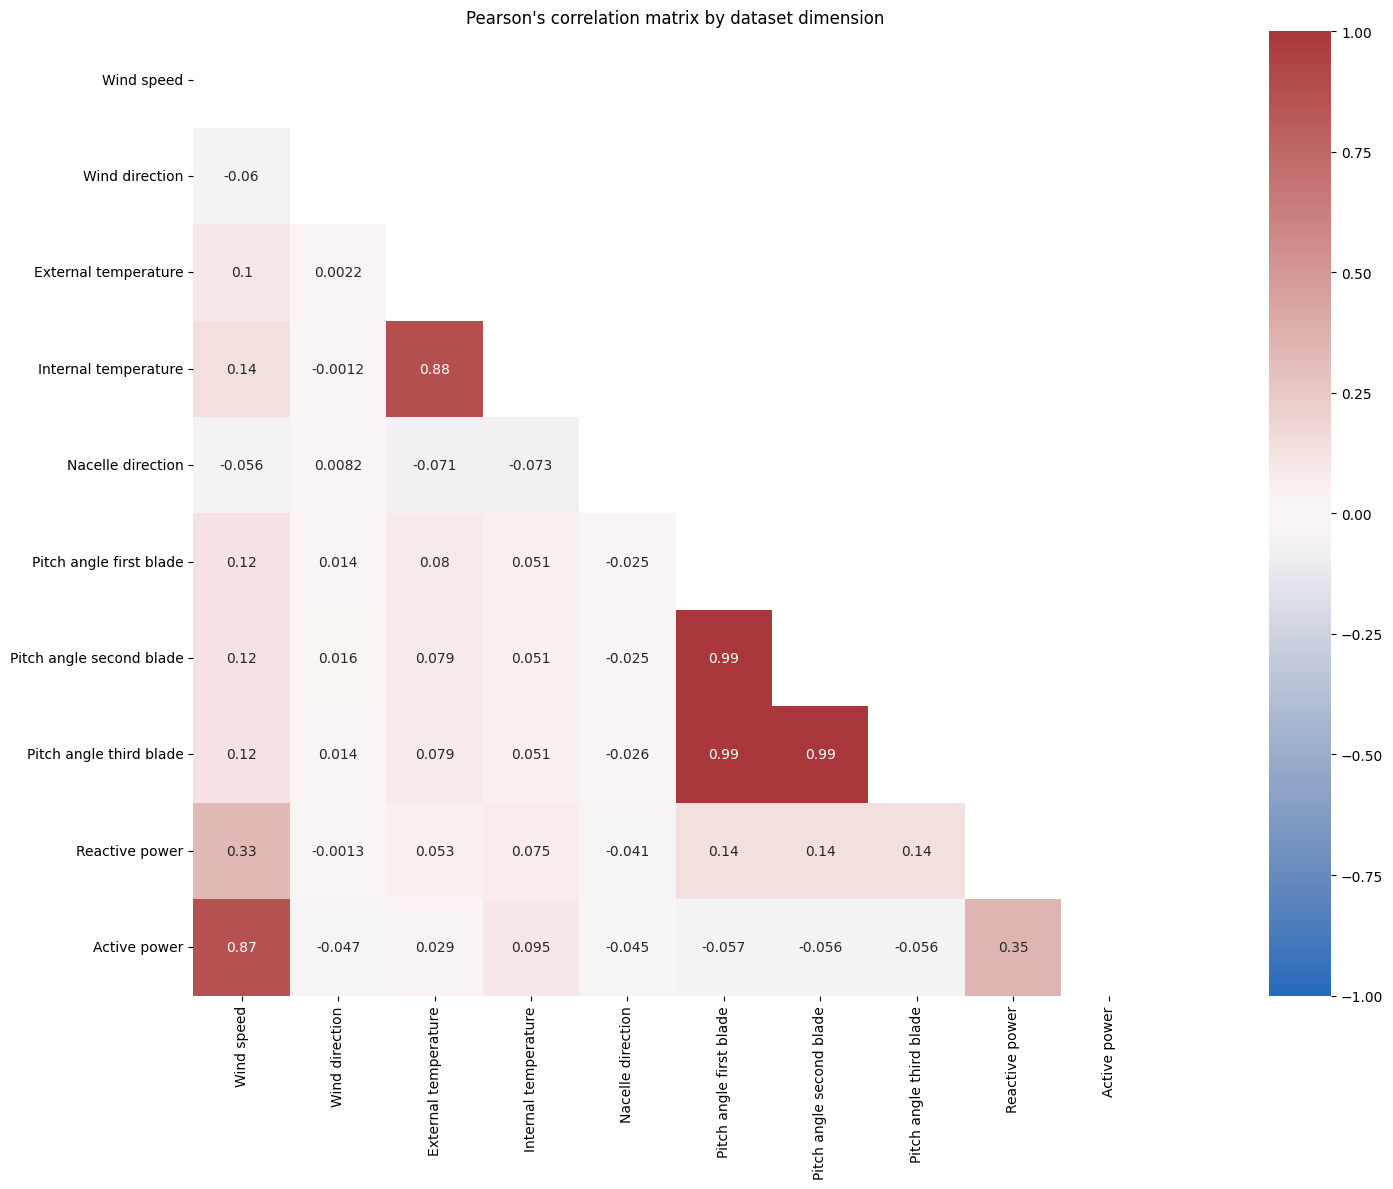

In [44]:
draw_dimensions_correlation_matrix(
    timeseries_dataset,
    'pearson',
    'Pearson\'s correlation matrix by dataset dimension',
)

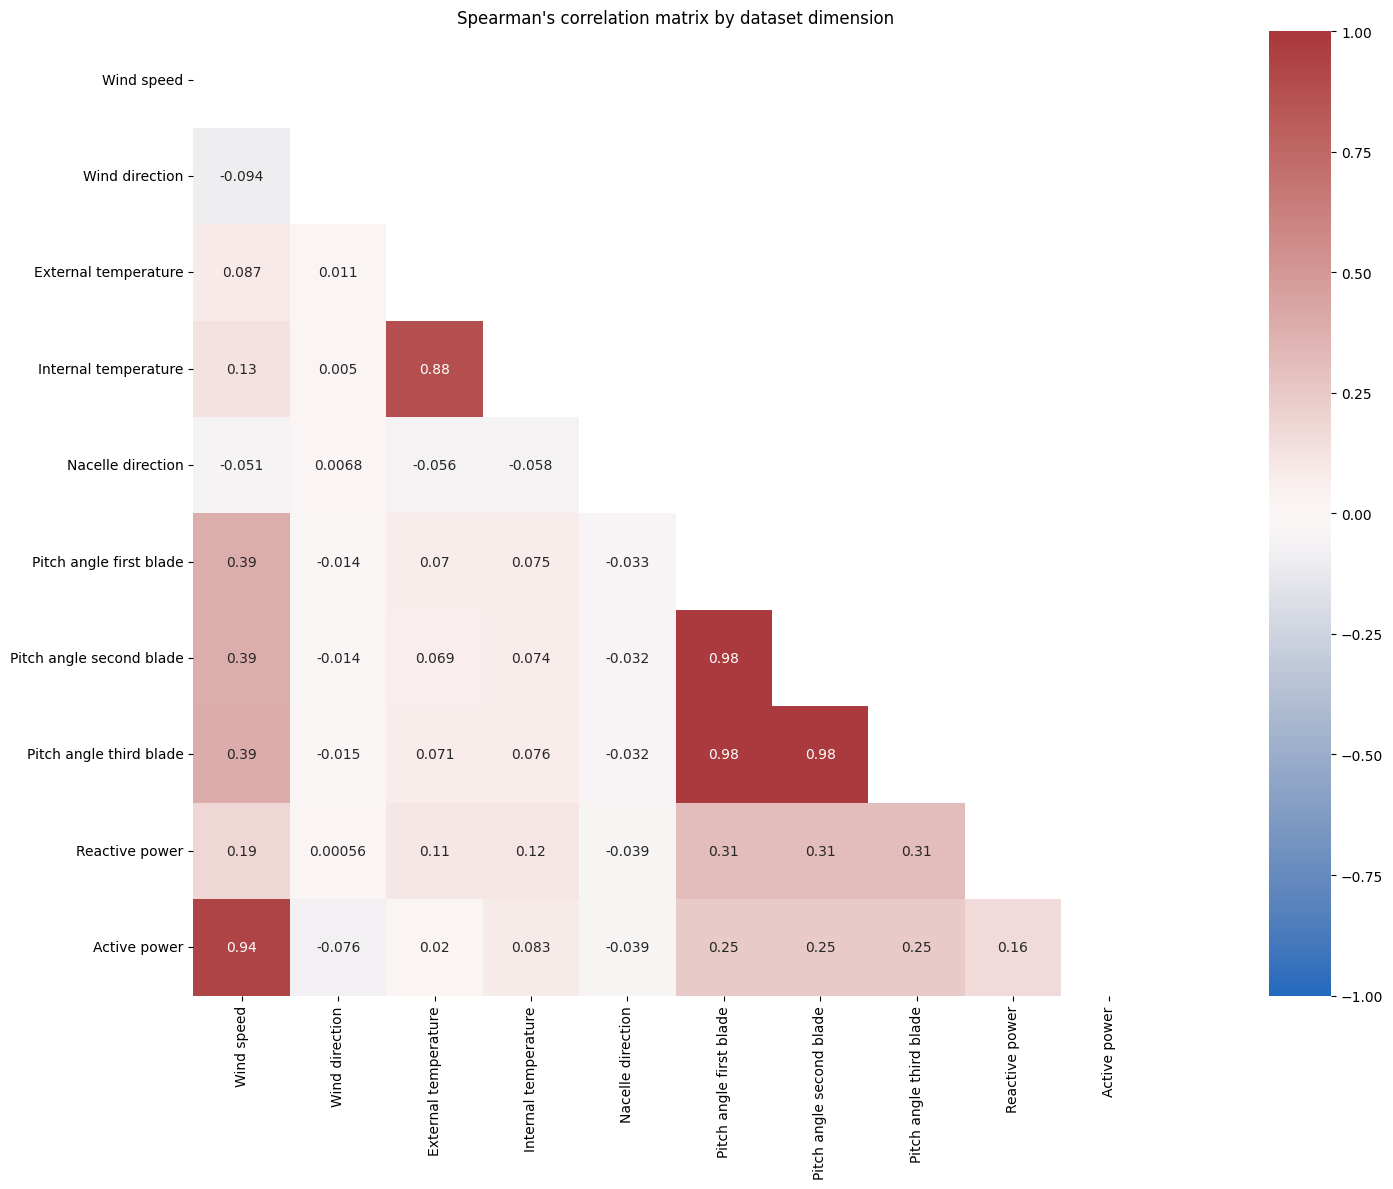

In [45]:
draw_dimensions_correlation_matrix(
    timeseries_dataset,
    'spearman',
    'Spearman\'s correlation matrix by dataset dimension',
)

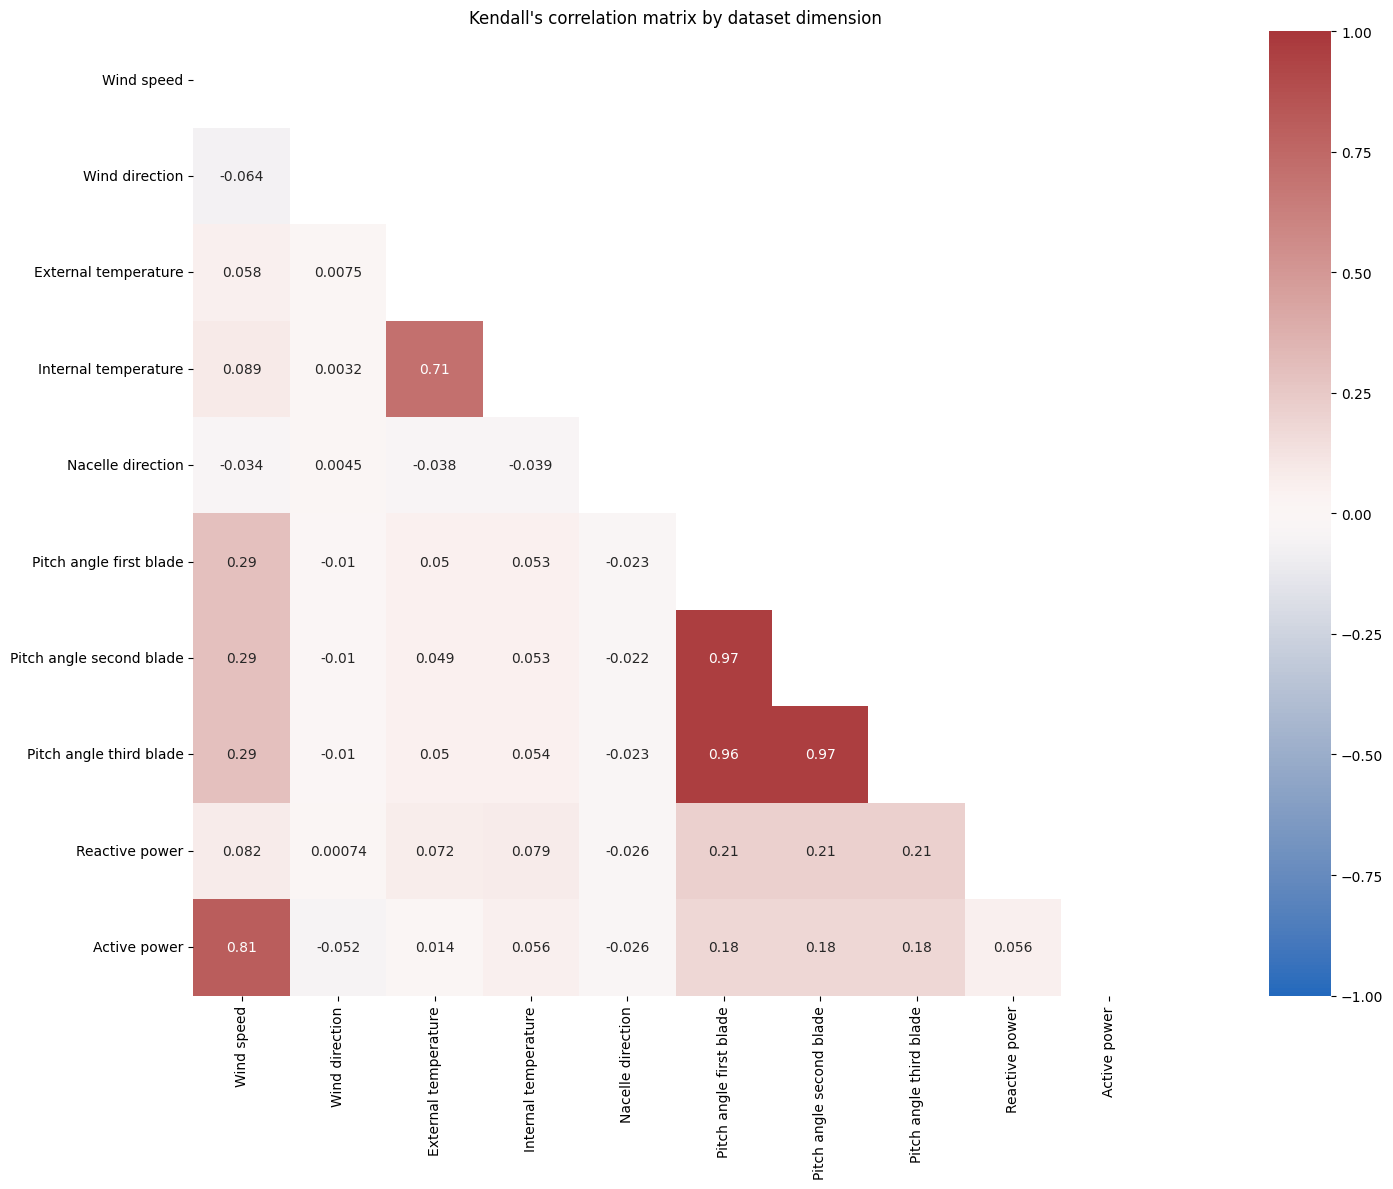

In [46]:
draw_dimensions_correlation_matrix(
    timeseries_dataset,
    'kendall',
    'Kendall\'s correlation matrix by dataset dimension',
)

### Pearson's correlation between turbines

In [47]:
def draw_turbine_correlation_matrices_by_dimension(
    timeseries_dataset: pd.DataFrame,
    correlation_function: str,
):

    # Initialize heatmap
    turbine_heatmap = Heatmap(
        maximum_value=1,
        minimum_value=-1,
        show_values=False,
        color_map=sns.color_palette("vlag", as_cmap=True),
        square_ratio=True,
        symmetric=True,
    )

    # Retrieve dimensions
    dimensions = timeseries_dataset.get_dataframe().drop(columns=['TURBINE', 'DAY', 'TIMESLOT']).columns

    # For each dimension, compute correlation matrix
    for dimension in dimensions:

        # Define dimension label
        dimension_label = dimension.replace('_', ' ').capitalize()
        
        # Pivot dataset
        turbine_pivot_dataset = timeseries_dataset.pivot_on_dimensions(
            column_dimensions=['TURBINE'],
            index_dimensions=['DAY', 'TIMESLOT'],
            values_dimension=dimension
        )
    
        # Compute correlation
        correlation_matrix = turbine_pivot_dataset.get_dataframe().corr(method=correlation_function)
    
        # Initialize plot
        plots = Plots(1, 2, 30, 12, width_ratios=[38, 1])
        heatmap_plot = plots.get_plot_from_list_by_index(0)
        colormap_plot = plots.get_plot_from_list_by_index(1)
        
        # Draw heatmap
        turbine_heatmap.draw_on_plot(correlation_matrix, heatmap_plot, colormap_plot)
        
        # Configure plot
        heatmap_plot.set_x_axis_ticks(np.arange(0, turbine_pivot_dataset.get_dataframe().shape[1], 1))
        heatmap_plot.set_y_axis_ticks(np.arange(0, turbine_pivot_dataset.get_dataframe().shape[1], 1))
        heatmap_plot.set_x_axis_ticks_labels(turbine_pivot_dataset.get_dataframe().columns, 90)
        heatmap_plot.set_y_axis_ticks_labels(turbine_pivot_dataset.get_dataframe().columns)
        heatmap_plot.set_axis_labels('Turbine', 'Turbine')
        heatmap_plot.set_title(f'{dimension_label}: {correlation_function.capitalize()}\'s correlation matrix by turbine')
        plots.set_tight_layout()
        
        # Output destination
        output_directory = FileManager.directory_resolve(OUTPUT_PATH, dimension.lower(), 'correlation_matrices')
        output_file = FileManager.file_resolve_path(output_directory, f'turbine_correlation_matrix_{correlation_function}.png')
        FileManager.directory_create(output_directory)

        # Save plot
        plots.save(output_file)
        del plots

In [48]:
draw_turbine_correlation_matrices_by_dimension(
    timeseries_dataset,
    'pearson',
)

In [49]:
draw_turbine_correlation_matrices_by_dimension(
    timeseries_dataset,
    'spearman',
)

In [50]:
draw_turbine_correlation_matrices_by_dimension(
    timeseries_dataset,
    'kendall',
)

## Dimensions breakdown

In [19]:
def draw_histograms_by_turbine(
    timeseries_dataset: pd.DataFrame,
    dimension: str,
    title: str,
    x_axis_label: str,
    y_axis_label: str,
    left_boundary: float,
    right_boundary: float,
    destination_subfolder: str
):

    # Create new histogram
    histogram = Histogram(BINS, left_boundary, right_boundary)
    
    # Iterate over all turbines
    for (turbine, ), dataset_slice in timeseries_dataset.slice_on_dimensions(['TURBINE'], True):
    
        # Create new plots
        plots = Plots(1, 1, HISTOGRAM_ROW_RATIO, COL_RATIO)
        plot = plots.get_plot_from_list_by_index(0)
    
        # Configure plot
        plot.toggle_top_and_right_border(False)
        plot.set_axis_labels(x_axis_label, y_axis_label)
        plot.set_title(f'TURBINE {turbine}: {title}')
        plot.set_x_axis_boundaries(left_boundary, right_boundary)
    
        # Draw histogram
        histogram.draw_on_plot(dataset_slice.get_dataframe().dropna()[dimension], plot)
    
        # Define destination path
        filename = f'turbine_{str(turbine).zfill(3)}.png'
    
        # Create destination path
        output_directory = FileManager.directory_resolve(OUTPUT_PATH, destination_subfolder, 'distribution')
        output_destination = FileManager.file_resolve_path(output_directory, filename)
        FileManager.directory_create(output_directory)
        
        # Show histogram
        plots.set_tight_layout()
        plots.save(output_destination)
    
        # Close all plots
        del plots

In [56]:
def draw_timeseries_by_turbine(
    timeseries_dataset: pd.DataFrame,
    dimension: str,
    title: str,
    x_axis_label: str,
    y_axis_label: str,
    highlight_missing_values: bool,
    destination_subfolder: str
):

    # Create new histogram
    lineplot = Lineplot(highlight_missing_values=highlight_missing_values)
    
    # Iterate over all turbines
    for (turbine, ), dataset_slice in timeseries_dataset.slice_on_dimensions(['TURBINE'], False):
    
        # Create new plots
        plots = Plots(1, 1, TIMESERIES_ROW_RATIO, COL_RATIO)
        plot = plots.get_plot_from_list_by_index(0)
    
        # Configure plot
        plot.toggle_top_and_right_border(False)
        plot.set_axis_labels(x_axis_label, y_axis_label)
        plot.set_title(f'TURBINE {turbine}: {title}')
        plot.set_x_axis_boundaries(0, dataset_slice.get_dataframe().shape[0])
    
        # Draw lineplot
        lineplot.draw_on_plot(dataset_slice.get_dataframe()[dimension], plot)
    
        # Configure ticks and grid
        daily_index, daily_labels = Timeseries.get_daily_index_and_labels_from_timeseries_index(dataset_slice.get_dataframe().index)
        plot.set_x_axis_ticks(daily_index)
        plot.set_x_axis_ticks_labels(daily_labels, rotation=45)
        plot.toggle_x_axis_grid(True)
    
        # Define destination path
        filename = f'turbine_{str(turbine).zfill(3)}.png'
    
        # Create destination path
        output_directory = FileManager.directory_resolve(OUTPUT_PATH, destination_subfolder, 'timeseries')
        output_destination = FileManager.file_resolve_path(output_directory, filename)
        FileManager.directory_create(output_directory)
    
        # Show histogram
        plots.set_tight_layout()
        plots.save(output_destination)
        
        # Close all plots
        del plots

### External temperature

#### Value distribution

In [57]:
external_temperature_left_boundary = timeseries_dataset.get_dataframe().EXTERNAL_TEMPERATURE.min() * 1.1
external_temperature_right_boundary = timeseries_dataset.get_dataframe().EXTERNAL_TEMPERATURE.max() * 1.1

In [58]:
draw_histograms_by_turbine(
    timeseries_dataset,
    'EXTERNAL_TEMPERATURE',
    'External temperature distribution',
    'External temperature [°C]',
    'Frequency',
    external_temperature_left_boundary,
    external_temperature_right_boundary,
    'external_temperature'
)

#### Timeseries

In [59]:
draw_timeseries_by_turbine(
    timeseries_dataset,
    'EXTERNAL_TEMPERATURE',
    'External temperature timeseries',
    'Timestamp',
    'External temperature [°C]',
    True,
    'external_temperature'
)

### Internal temperature

#### Value distribution

In [60]:
internal_temperature_left_boundary = timeseries_dataset.get_dataframe().INTERNAL_TEMPERATURE.min() * 1.1
internal_temperature_right_boundary = timeseries_dataset.get_dataframe().INTERNAL_TEMPERATURE.max() * 1.1

In [61]:
draw_histograms_by_turbine(
    timeseries_dataset,
    'INTERNAL_TEMPERATURE',
    'Internal temperature distribution',
    'Internal temperature [°C]',
    'Frequency',
    internal_temperature_left_boundary,
    internal_temperature_right_boundary,
    'internal_temperature'
)

#### Timeseries

In [62]:
draw_timeseries_by_turbine(
    timeseries_dataset,
    'INTERNAL_TEMPERATURE',
    'Internal temperature timeseries',
    'Timestamp',
    'Internal temperature [°C]',
    True,
    'internal_temperature'
)

### Nacelle direction

#### Value distribution

In [63]:
nacelle_direction_left_boundary = timeseries_dataset.get_dataframe().NACELLE_DIRECTION.min() * 1.1
nacelle_direction_right_boundary = timeseries_dataset.get_dataframe().NACELLE_DIRECTION.max() * 1.1

In [64]:
draw_histograms_by_turbine(
    timeseries_dataset,
    'NACELLE_DIRECTION',
    'Nacelle direction distribution',
    'Nacelle direction [°]',
    'Frequency',
    nacelle_direction_left_boundary,
    nacelle_direction_right_boundary,
    'nacelle_direction'
)

#### Timeseries

In [65]:
draw_timeseries_by_turbine(
    timeseries_dataset,
    'NACELLE_DIRECTION',
    'Nacelle direction timeseries',
    'Timestamp',
    'Nacelle direction [°]',
    True,
    'nacelle_direction'
)

### Pitch angles

#### Value distribution

In [66]:
pitch_angle_left_boundary = 1.1 * min(
    timeseries_dataset.get_dataframe().PITCH_ANGLE_FIRST_BLADE.min(),
    timeseries_dataset.get_dataframe().PITCH_ANGLE_SECOND_BLADE.min(),
    timeseries_dataset.get_dataframe().PITCH_ANGLE_THIRD_BLADE.min()
)

pitch_angle_right_boundary = 1.1 * max(
    timeseries_dataset.get_dataframe().PITCH_ANGLE_FIRST_BLADE.max(),
    timeseries_dataset.get_dataframe().PITCH_ANGLE_SECOND_BLADE.max(),
    timeseries_dataset.get_dataframe().PITCH_ANGLE_THIRD_BLADE.max()
)

In [67]:
draw_histograms_by_turbine(
    timeseries_dataset,
    'PITCH_ANGLE_FIRST_BLADE',
    'First blade pitch angle distribution',
    'Pitch angle [°]',
    'Frequency',
    pitch_angle_left_boundary,
    pitch_angle_right_boundary,
    'pitch_angle_first_blade'
)

In [68]:
draw_histograms_by_turbine(
    timeseries_dataset,
    'PITCH_ANGLE_SECOND_BLADE',
    'Second blade pitch angle distribution',
    'Pitch angle [°]',
    'Frequency',
    pitch_angle_left_boundary,
    pitch_angle_right_boundary,
    'pitch_angle_second_blade'
)

In [69]:
draw_histograms_by_turbine(
    timeseries_dataset,
    'PITCH_ANGLE_THIRD_BLADE',
    'Third blade pitch angle distribution',
    'Pitch angle [°]',
    'Frequency',
    pitch_angle_left_boundary,
    pitch_angle_right_boundary,
    'pitch_angle_third_blade'
)

### Wind Speed

#### Value distribution

In [70]:
wind_speed_left_boundary = timeseries_dataset.get_dataframe().WIND_SPEED.min() * 1.1
wind_speed_right_boundary = timeseries_dataset.get_dataframe().WIND_SPEED.max() * 1.1

In [71]:
draw_histograms_by_turbine(
    Dataset(timeseries_dataset.get_dataframe()[['TURBINE', 'WIND_SPEED']].dropna()),
    'WIND_SPEED',
    'Wind speed distribution',
    'Wind speed [m/s]',
    'Frequency',
    wind_speed_left_boundary,
    wind_speed_right_boundary,
    'wind_speed'
)

#### Timeseries

In [72]:
draw_timeseries_by_turbine(
    timeseries_dataset,
    'WIND_SPEED',
    'Wind speed timeseries',
    'Timestamp',
    'Wind speed [m/s]',
    True,
    'wind_speed'
)

### Wind Direction

#### Value distribution

In [73]:
wind_direction_left_boundary = timeseries_dataset.get_dataframe().WIND_DIRECTION.min() * 1.1
wind_direction_right_boundary = timeseries_dataset.get_dataframe().WIND_DIRECTION.max() * 1.1

In [74]:
draw_histograms_by_turbine(
    timeseries_dataset,
    'WIND_DIRECTION',
    'Wind direction distribution',
    'Wind direction [°]',
    'Frequency',
    wind_direction_left_boundary,
    wind_direction_right_boundary,
    'wind_direction'
)

#### Timeseries

In [75]:
draw_timeseries_by_turbine(
    timeseries_dataset,
    'WIND_DIRECTION',
    'Wind direction timeseries',
    'Timestamp',
    'Wind direction [°]',
    True,
    'wind_direction'
)

### Reactive Power

#### Value distribution

In [76]:
reactive_power_left_boundary = timeseries_dataset.get_dataframe().REACTIVE_POWER.min() * 1.1
reactive_power_right_boundary = timeseries_dataset.get_dataframe().REACTIVE_POWER.max() * 1.1

In [77]:
draw_histograms_by_turbine(
    timeseries_dataset,
    'REACTIVE_POWER',
    'Reactive power distribution',
    'Reactive power [kW]',
    'Frequency',
    reactive_power_left_boundary,
    reactive_power_right_boundary,
    'reactive_power'
)

#### Timeseries

In [78]:
draw_timeseries_by_turbine(
    timeseries_dataset,
    'REACTIVE_POWER',
    'Reactive power timeseries',
    'Timestamp',
    'Reactive power [kW]',
    True,
    'reactive_power'
)

### Active Power

#### Value distribution

In [79]:
active_power_left_boundary = timeseries_dataset.get_dataframe().ACTIVE_POWER.min() * 1.1
active_power_right_boundary = timeseries_dataset.get_dataframe().ACTIVE_POWER.max() * 1.1

In [82]:
draw_histograms_by_turbine(
    timeseries_dataset,
    'ACTIVE_POWER',
    'Active power distribution',
    'Active power [kW]',
    'Frequency',
    active_power_left_boundary,
    active_power_right_boundary,
    'active_power'
)

#### Timeseries

In [83]:
draw_timeseries_by_turbine(
    timeseries_dataset,
    'ACTIVE_POWER',
    'Active power timeseries',
    'Timestamp',
    'Active power [kW]',
    True,
    'active_power'
)

## Relationships between dimensions

In [16]:
pairplot_scatterplot = Scatterplot(opacity=0.01)

In [17]:
dimensions = list(timeseries_dataset.get_dataframe().drop(columns=['TURBINE', 'DAY', 'TIMESLOT']).columns)

In [18]:
for (turbine, ), dataset_slice in timeseries_dataset.slice_on_dimensions(['TURBINE'], False):
    
    # Define new scatterplot grid
    plots = Plots(len(dimensions), len(dimensions), 8, 8)

    # Represent pair relatiomships through scatterplots
    for row, dimension_x_axis in enumerate(dimensions):
        for column, dimension_y_axis in enumerate(dimensions):
    
            # Retrieve plot from grid
            plot = plots.get_plot_from_grid_by_indexes(row, column)
            
            # If dimensions are equals, leave the plot blank
            if row <= column:
                plot.empty()
                continue
    
            # Otherwise draw scatterplot
            pairplot_scatterplot.draw_on_plot(
                dataset_slice.get_dataframe()[dimension_y_axis],
                dataset_slice.get_dataframe()[dimension_x_axis],
                plot
            ) 
    
            # Configure plot
            plot.toggle_top_and_right_border(False)
            plot.set_axis_labels(
                dimension_y_axis.replace('_', ' ').capitalize(), 
                dimension_x_axis.replace('_', ' ').capitalize()
            )

    # Tight layout
    plots.set_tight_layout()
    
    # Define output destination and dump file
    output_directory = FileManager.directory_resolve(OUTPUT_PATH, 'dimensions_pair_relationships')
    output_file = FileManager.file_resolve_path(output_directory, f'dimensions_pair_relationships_turbine_{str(turbine).zfill(3)}.png')
    FileManager.directory_create(output_directory)
    plots.save(output_file)

    # Go to the next plot
    plt.close()
    del plots